In this file:

The goal is to perform a backtesting on the Prestige investment strategy

0. Getting the file    


1. Data Cleaning:    
    • Data ending by the end of 2020-06-01 (too many missing data in 2020);    
    • Removing the missing values 
    • Removing market cap lower than 50M


2. Computing the 2 metrics:   
    2.1 Earnings Yield --> EBIT / (Market Capital + Preferred Stock + Net Debt)    
    2.2 Return on Capital --> EBIT / (Working Capital + Net Fixed Assets)        
    2.3 Descriptive stats and removing outliers    
    
    • Remove firms with Earnings Yield higher than 0.2 (similar to excluding Price to Earnings smaller than 5, as indicated in the book, on page 97;    
    • Remove top 2.4%, according to initial descriptive stats. Why? Because there are also absurd values for RoC. The 2.4% is chosen because it is equivalent to the percentage removed from the Earnings Yield
        
        
3. Ranking the stocks on both indicators, per day. Then, sum those rankings, and rank from smallest to largest (getting the final ranking) Ranking ranking ranking   


4. Get the list of the top 50 stocks per day    


5. Check for bronze: create a dataframe of stocks, per day, which are new to the list over the past week (rolling window). Save the date. The index should be each date    


6. Backtest the strategy: Buying the 'bronze' stocks, and selling them after one week

In [1]:
import pandas as pd
import numpy as np

from dateutil.relativedelta import relativedelta

### 0. Get the panel data file

In [2]:
df = pd.read_csv('./panel_data_extraction.csv')
df['Date'] = pd.to_datetime(df['Date']) #turning dates to datetime

In [3]:
pd.concat([df.head(3),df.tail(3)])

,Unnamed: 0,Date,Firm,Price,MC,EBIT,WC,NFA,PS,ND
0,2015-11-27_ECL.N,2015-11-27,ECL.N,118.91,35114540.0,1571400.0,-316900.0,6909900.0,0.0,6261500.0
1,2015-11-30_ECL.N,2015-11-30,ECL.N,119.16,35188370.0,1571400.0,-316900.0,6909900.0,0.0,6261500.0
2,2015-12-01_ECL.N,2015-12-01,ECL.N,119.67,35338970.0,1571400.0,-316900.0,6909900.0,0.0,6261500.0
4183115,2020-11-25_OAS.OQ,2020-11-25,OAS.OQ,34.12,682400.0,NaN,NaN,3636138.0,NaN,NaN
4183116,2020-11-26_OAS.OQ,2020-11-26,OAS.OQ,34.12,682400.0,NaN,NaN,3636138.0,NaN,NaN
4183117,2020-11-27_OAS.OQ,2020-11-27,OAS.OQ,34.13,682600.0,NaN,NaN,3636138.0,NaN,NaN


In [4]:
#How many rows and columns?
df.shape

(4183118, 10)

### 1. Data Cleaning

In [5]:
#First of all, I want to conserve the original dataframe, so that I don't lose stock prices along the way, so let's 
#create a new one:

df_new = df

#Excluding data from 2020
df_new = df_new.loc[df['Date'] < '2020-06-01']

#Removing missing data
df_new = df_new.dropna()

#Removing market cap lower than 50M
df_new = df_new.loc[df['MC'] > 50000]

### 2. Computing the 2 metrics

##### 2.0 Initial Descriptive stats

In [6]:
df_new.describe()

,Price,MC,EBIT,WC,NFA,PS,ND
count,2.236058e+06,2.236058e+06,2.236058e+06,2.236058e+06,2.236058e+06,2.236058e+06,2.236058e+06
mean,3.577937e+02,1.023755e+07,5.640172e+05,7.311291e+05,2.478355e+06,1.557420e+07,1.561687e+06
std,5.892117e+04,5.420661e+07,2.926339e+06,4.872204e+06,9.920974e+06,1.974098e+08,7.898592e+06
min,1.310000e-02,5.001000e+04,-4.803396e+07,-5.417234e+07,-1.324400e+07,0.000000e+00,-1.608702e+08
25%,1.132000e+01,3.055600e+05,-1.070600e+04,2.549700e+04,8.915600e+04,0.000000e+00,-4.684700e+04
50%,2.671000e+01,1.209720e+06,4.658000e+04,1.326760e+05,3.825070e+05,0.000000e+00,6.748700e+04
75%,5.714000e+01,4.500668e+06,2.970000e+05,4.731240e+05,1.337067e+06,0.000000e+00,9.321610e+05
max,1.843014e+07,4.142027e+09,7.614300e+07,1.757371e+08,1.949847e+08,9.762000e+09,1.713010e+08


##### 2.1 Earnings Yield   
EBIT / (Market Capital + Preferred Stock + Net Debt)

In [7]:
df_new.loc[:, 'EY'] = (df_new['EBIT']) / (df_new['MC'] + df_new['PS'] + df_new['ND'])

##### 2.2 Return on Capital (RoC)

EBIT / (Working Capital + Net Fixed Assets)   

In [8]:
df_new.loc[:,'RoC'] = (df_new['EBIT']) / (df_new['WC'] + df_new['NFA'])

##### 2.3 Descriptive stats of the metrics

In [9]:
df_new.describe().round(1)

,Price,MC,EBIT,WC,NFA,PS,ND,EY,RoC
count,2236058.0,2.236058e+06,2236058.0,2236058.0,2236058.0,2.236058e+06,2236058.0,2236058.0,2236058.0
mean,357.8,1.023755e+07,564017.2,731129.1,2478355.4,1.557420e+07,1561687.3,0.0,0.2
std,58921.2,5.420661e+07,2926338.7,4872203.9,9920973.5,1.974098e+08,7898592.2,28.3,16.0
min,0.0,5.001000e+04,-48033955.0,-54172338.0,-13244000.0,0.000000e+00,-160870190.0,-4325.7,-557.8
25%,11.3,3.055600e+05,-10706.0,25497.0,89156.0,0.000000e+00,-46847.0,-0.0,-0.1
50%,26.7,1.209720e+06,46580.0,132676.0,382507.0,0.000000e+00,67487.0,0.0,0.1
75%,57.1,4.500668e+06,297000.0,473124.0,1337067.0,0.000000e+00,932161.0,0.1,0.2
max,18430140.0,4.142027e+09,76143000.0,175737135.0,194984700.0,9.762000e+09,171301000.0,37818.3,1158.3


In [10]:
# Removing all the Earning Yield values higher than 0.2:

print('This removes {} rows, which represents {}% of the data'.format(len(df_new) - len(df_new.loc[df_new['EY']<0.2]), (len(df_new) - len(df_new.loc[df_new['EY']<0.2]))/len(df_new)*100))

df_new = df_new.loc[df_new['EY']<0.2]

This removes 53365 rows, which represents 2.3865660014185677% of the data


In [11]:
#Removing the top 2.4% of RoC
df_new = df_new.loc[df_new['RoC'] < 1.5857]

In [12]:
#Final descriptive stats:
df_new.describe().round(1)

,Price,MC,EBIT,WC,NFA,PS,ND,EY,RoC
count,2131300.0,2.131300e+06,2131300.0,2131300.0,2131300.0,2.131300e+06,2131300.0,2131300.0,2131300.0
mean,371.8,1.043016e+07,559736.3,757480.6,2569972.2,1.606933e+07,1580779.1,-0.1,-0.3
std,60350.1,5.530771e+07,2957551.1,4973707.3,10136878.7,2.017803e+08,8014367.8,9.1,7.5
min,0.0,5.001000e+04,-48033955.0,-54172338.0,-13244000.0,0.000000e+00,-160870190.0,-4325.7,-557.8
25%,11.7,3.192900e+05,-10611.0,27727.0,97789.0,0.000000e+00,-46250.0,-0.0,-0.1
50%,27.2,1.272950e+06,45880.0,137486.0,404410.0,0.000000e+00,74107.0,0.0,0.1
75%,57.6,4.615372e+06,291000.0,484766.0,1400757.0,0.000000e+00,959400.0,0.1,0.2
max,18430140.0,4.142027e+09,76143000.0,175737135.0,194984700.0,9.762000e+09,171301000.0,0.2,1.6


### 3. Rank the top performing stocks, per day

In [13]:
#Sort the dataframe by date, then by firm
df_new = df_new.sort_values(by = ['Date', 'Firm']).reset_index(drop = True)

In [14]:
pd.concat([df_new.head(), df_new.tail()])

,Unnamed: 0,Date,Firm,Price,MC,EBIT,WC,NFA,PS,ND,EY,RoC
0,2015-11-27_0206.HK,2015-11-27,0206.HK,1.492,1088960.0,41376.0,921209.0,1406741.00,0.0,99747.0,0.034808,0.017774
1,2015-11-27_1316.HK,2015-11-27,1316.HK,8.370,20906630.0,2438567.0,4098460.0,6412636.00,0.0,1736155.0,0.107697,0.231999
2,2015-11-27_3665.TW,2015-11-27,3665.TW,130.340,12606880.0,981206.0,2973752.0,4386029.00,0.0,-858628.0,0.083519,0.133320
3,2015-11-27_4966.TWO,2015-11-27,4966.TWO,229.000,17416720.0,1238876.0,3238060.0,6461246.00,0.0,-2887751.0,0.085269,0.127728
4,2015-11-27_A,2015-11-27,A,41.970,13908980.0,626000.0,2690000.0,4243000.00,0.0,-386000.0,0.046292,0.090293
2131295,2020-05-29_WNDW.PK,2020-05-29,WNDW.PK,3.050,161530.0,-7353.0,14591.0,15967.13,0.0,-14152.0,-0.049892,-0.240623
2131296,2020-05-29_WOR.N,2020-05-29,WOR.N,29.920,1661970.0,27615.0,594941.0,820821.00,0.0,552467.0,0.012470,0.019505
2131297,2020-05-29_WRK.N,2020-05-29,WRK.N,28.060,7274700.0,-72900.0,2015800.0,10630600.00,0.0,9179500.0,-0.004430,-0.005764
2131298,2020-05-29_WWD.OQ,2020-05-29,WWD.OQ,68.580,4271820.0,302112.0,818533.0,1992677.00,0.0,685213.0,0.060946,0.107467
2131299,2020-05-29_ZS.OQ,2020-05-29,ZS.OQ,98.090,12802540.0,-107703.0,1157892.0,484829.00,0.0,-507501.0,-0.008760,-0.065564


In [15]:
#Ranking the RoC per date:
df_new['Rank_RoC'] = df_new.groupby('Date')['RoC'].rank(ascending = False)

#Ranking the EY per date:
df_new['Rank_EY'] = df_new.groupby('Date')['EY'].rank(ascending = False)

In [16]:
df_new.head(10)

,Unnamed: 0,Date,Firm,Price,MC,EBIT,WC,NFA,PS,ND,EY,RoC,Rank_RoC,Rank_EY
0,2015-11-27_0206.HK,2015-11-27,0206.HK,1.4920,1088960.0,41376.0,921209.0,1406741.0,0.0,99747.0,0.034808,0.017774,1128.0,966.0
1,2015-11-27_1316.HK,2015-11-27,1316.HK,8.3700,20906630.0,2438567.0,4098460.0,6412636.0,0.0,1736155.0,0.107697,0.231999,330.0,149.0
2,2015-11-27_3665.TW,2015-11-27,3665.TW,130.3400,12606880.0,981206.0,2973752.0,4386029.0,0.0,-858628.0,0.083519,0.133320,631.0,329.0
3,2015-11-27_4966.TWO,2015-11-27,4966.TWO,229.0000,17416720.0,1238876.0,3238060.0,6461246.0,0.0,-2887751.0,0.085269,0.127728,658.0,311.0
4,2015-11-27_A,2015-11-27,A,41.9700,13908980.0,626000.0,2690000.0,4243000.0,0.0,-386000.0,0.046292,0.090293,839.5,840.5
5,2015-11-27_A.N,2015-11-27,A.N,41.9700,13908980.0,626000.0,2690000.0,4243000.0,0.0,-386000.0,0.046292,0.090293,839.5,840.5
6,2015-11-27_AAOI.OQ,2015-11-27,AAOI.OQ,18.5600,312460.0,12186.0,79848.0,165398.0,0.0,27224.0,0.035875,0.049689,1030.0,954.0
7,2015-11-27_AAON.OQ,2015-11-27,AAON.OQ,25.1500,1360430.0,71339.0,80800.0,178918.0,0.0,-30432.0,0.053638,0.274679,265.0,740.0
8,2015-11-27_AAP.N,2015-11-27,AAP.N,164.8400,12072310.0,818296.0,1143269.0,2460648.0,0.0,1122977.0,0.062014,0.227057,339.0,622.0
9,2015-11-27_AAPL.OQ,2015-11-27,AAPL.OQ,29.4525,656829500.0,62828000.0,27863000.0,128249000.0,0.0,18478000.0,0.093036,0.402455,140.0,244.0


In [17]:
#Create a column to sum the rankings:
df_new['Final_Rating'] = df_new['Rank_RoC'] + df_new['Rank_EY']

#Turn the final rating to a final ranking:
df_new['Final_Ranking'] = df_new.groupby('Date')['Final_Rating'].rank()

### 4. Get the top 50 best stocks, per day

In [18]:
#First, sort the values by date, then by final ranking
df_new = df_new.sort_values(['Date','Final_Ranking']).reset_index(drop = True)

In [19]:
#Create a dataframe including the top 50 firms per date only
top50 = df_new.groupby('Date')['Date', 'Firm','Price','RoC', 'EY','Final_Ranking'].head(50)

C:\Users\jlbgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [20]:
#Now, a dataframe with one row per date, with the list of top 50 firms of the day:
top_50_daily = pd.DataFrame(index = df_new['Date'].unique(), columns = ['top_50', 'top_50_trailing_week'])

#inserting top 50 per day:
for date in top_50_daily.index:
    top_50_daily.loc[date, 'top_50'] = [*top50.loc[top50['Date'] == date, 'Firm']]
    
#inserting the list of firms that were top 50 during the week (rolling winsow):
for date in top_50_daily.index[5:]:
    top_week = top_50_daily.loc[date + relativedelta(days = -7): date + relativedelta(days = -1), 'top_50']
    #get the list of the trailing week, with no duplicates:
    top_50_daily.loc[date, 'top_50_trailing_week'] = [*set([*top_week.apply(pd.Series).stack().reset_index()[0]])]

### 5. Check for bronze: are there any new stocks on the week (trailing)?

In [21]:
top_50_daily.head(7)

,top_50,top_50_trailing_week
2015-11-27,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, MVO.N, GILD.OQ...",NaN
2015-11-30,"[UAL.OQ, CCR.N, HA.OQ, BBSI.OQ, MVO.N, GILD.OQ...",NaN
2015-12-01,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN
2015-12-02,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, PPC.O...",NaN
2015-12-03,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN
2015-12-04,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, LFV..."
2015-12-07,"[UAL.OQ, BBSI.OQ, HA.OQ, GILD.OQ, SRLP.N, PPC....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, MMI..."


In [22]:
[*set(top_50_daily.loc['2015-12-04', 'top_50']).difference(top_50_daily.loc['2015-12-04', 'top_50_trailing_week'])]

['PII.N']

In [23]:
top_50_daily['bronze'] = np.nan

for date in top_50_daily.index[5:]:
    top_50_daily.loc[date, 'bronze'] = [*set(top_50_daily.loc[date, 'top_50']).difference(top_50_daily.loc[date, 'top_50_trailing_week'])]
    
#for whatever reason, the first element was not inserted as a list, so let's do it manually:
top_50_daily.iloc[5, 2] = [*set(top_50_daily.iloc[5, 0]).difference(top_50_daily.iloc[5, 1])]

In [24]:
top_50_daily.head(8)

,top_50,top_50_trailing_week,bronze
2015-11-27,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, MVO.N, GILD.OQ...",NaN,NaN
2015-11-30,"[UAL.OQ, CCR.N, HA.OQ, BBSI.OQ, MVO.N, GILD.OQ...",NaN,NaN
2015-12-01,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN,NaN
2015-12-02,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, PPC.O...",NaN,NaN
2015-12-03,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN,NaN
2015-12-04,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, LFV...",[PII.N]
2015-12-07,"[UAL.OQ, BBSI.OQ, HA.OQ, GILD.OQ, SRLP.N, PPC....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, MMI...",[CVLG.OQ]
2015-12-08,"[UAL.OQ, BBSI.OQ, HA.OQ, SRLP.N, GILD.OQ, PPC....","[CNC.N, H.N, STRA.OQ, TEN.N, CCR.N, LFVN.OQ, M...",[UNP.N]


### 6. Backtesting the Prestige Bronze Strategy

#### How frequently 'bronze' stocks appear, on a daily basis?


Bad key "text.kerning_factor" on line 4 in
C:\Users\jlbgo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


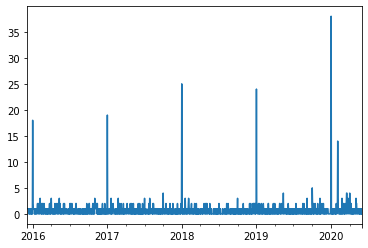

In [25]:
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).plot()

In [26]:
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).describe()

count    1171.000000
mean        0.727583
std         1.852718
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        38.000000
Name: bronze, dtype: float64

In [27]:
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).nlargest(6)

2020-01-01    38
2018-01-01    25
2019-01-01    24
2017-01-02    19
2016-01-01    18
2020-02-03    14
Name: bronze, dtype: int64

__A first obvious remark__: on the first trading day of each year, there are several new stocks appearing. I do not want to include these for the backtesting, so I'll remove them. Also, in the start of April, there was an abnormal amount of new stocks (due to the crisis). I'll remove these as well.

In [28]:
#removing these 4 dates, with abnormal values:
dates_remove = top_50_daily.loc['2015-12-04':,'bronze'].apply(len).nlargest(6).index
top_50_daily = top_50_daily.loc[~top_50_daily.index.isin(dates_remove)]

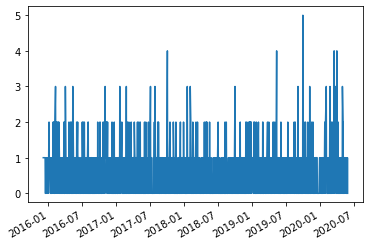

In [29]:
#plotting again
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).plot()

In [30]:
top_50_daily.loc['2015-12-04':,'bronze'].apply(len).describe()

count    1165.000000
mean        0.612876
std         0.760045
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: bronze, dtype: float64

#### Getting the daily returns of the stocks we are long on - we keep them for one week

In [31]:
top_50_daily.head(8)

,top_50,top_50_trailing_week,bronze
2015-11-27,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, MVO.N, GILD.OQ...",NaN,NaN
2015-11-30,"[UAL.OQ, CCR.N, HA.OQ, BBSI.OQ, MVO.N, GILD.OQ...",NaN,NaN
2015-12-01,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN,NaN
2015-12-02,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, PPC.O...",NaN,NaN
2015-12-03,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....",NaN,NaN
2015-12-04,"[UAL.OQ, CCR.N, BBSI.OQ, HA.OQ, GILD.OQ, SRLP....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, LFV...",[PII.N]
2015-12-07,"[UAL.OQ, BBSI.OQ, HA.OQ, GILD.OQ, SRLP.N, PPC....","[CNC.N, H.N, MVO.N, STRA.OQ, TEN.N, CCR.N, MMI...",[CVLG.OQ]
2015-12-08,"[UAL.OQ, BBSI.OQ, HA.OQ, SRLP.N, GILD.OQ, PPC....","[CNC.N, H.N, STRA.OQ, TEN.N, CCR.N, LFVN.OQ, M...",[UNP.N]


In [32]:
#setting the date as index on the dataframe df:
df.set_index('Date', inplace = True, drop = False)

#Computing the daily returns on each stock, on the whole period, on the df dataframe:
df['daily_return'] = df.groupby('Firm')['Price'].pct_change()

In [33]:
(df.groupby('Firm')['Price'].pct_change().index == df.index).all() #checking if it adds up

True

In [34]:
#Finally, here I'm inserting the daily returns of the chosen stocks, on the week we are going long on them
#Note that I am using the original 'df', because I don not want to lose price information
returns = pd.DataFrame(columns = ['Date','Firm','Price'])

for day in top_50_daily.index[4:len(top_50_daily)-5]:
    if type(top_50_daily.loc[day,'bronze']) == list and len(top_50_daily.loc[day,'bronze']) > 0:
        for firm in top_50_daily.loc[day,'bronze']:
            returns = returns.append(df.loc[df['Firm']==firm].loc[day +relativedelta(days = +1): day+ relativedelta(days = +7), ['Date','Firm','Price', 'daily_return']])

#### Cumulative sum of returns

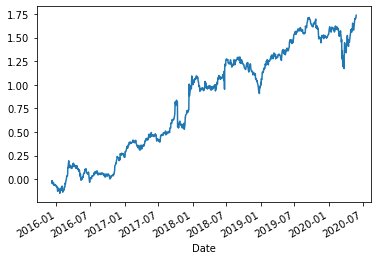

In [35]:
returns.groupby('Date')['daily_return'].mean().cumsum().plot()

#### Cumulative Product of returns

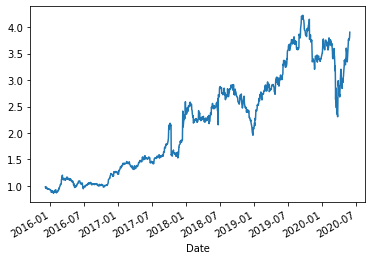

In [36]:
(returns.groupby('Date')['daily_return'].mean() +1).cumprod().plot()

#### Descriptive statistics of the investment strategy

Descriptive statistics

In [37]:
returns.groupby('Date')['daily_return'].mean().describe()

count    1142.000000
mean        0.001520
std         0.025469
min        -0.256486
25%        -0.008344
50%         0.001154
75%         0.011531
max         0.264335
Name: daily_return, dtype: float64

In [38]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns.groupby('Date')['daily_return'].mean().mean()*252*100
stdev = returns.groupby('Date')['daily_return'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 38.32%
Average yearly standard deviation: 40.43%
Sharpe Ratio: 0.9353234849530744


5 Worst performing stocks

In [39]:
returns.nsmallest(5, columns = 'daily_return')

,Date,Firm,Price,daily_return
2017-10-12,2017-10-12,JILL.N,20.3916,-0.510574
2019-11-08,2019-11-08,MED.N,74.3600,-0.270980
2018-06-18,2018-06-18,AMEH.OQ,20.1300,-0.221578
2020-03-18,2020-03-18,TDG.N,245.7900,-0.219739
2017-09-08,2017-09-08,LFVN.OQ,3.8800,-0.193347


#### Checking how these stocks performed the week before:

In [40]:
returns_reversed = pd.DataFrame(columns = ['Date','Firm','Price'])

for day in top_50_daily.index[4:len(top_50_daily)-5]:
    if type(top_50_daily.loc[day,'bronze']) == list and len(top_50_daily.loc[day,'bronze']) > 0:
        for firm in top_50_daily.loc[day,'bronze']:
            returns_reversed = returns_reversed.append(df.loc[df['Firm']==firm].loc[day +relativedelta(days = -6): day, ['Date','Firm','Price', 'daily_return']])

Cumulative sum of returns

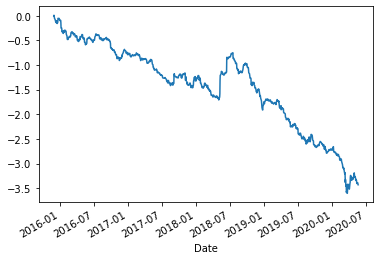

In [41]:
returns_reversed.groupby('Date')['daily_return'].mean().cumsum().plot()

Cumulative product of returns

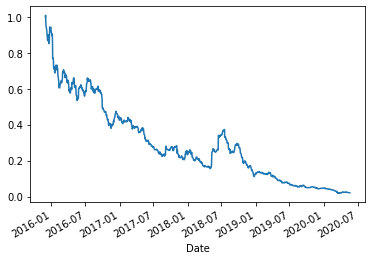

In [42]:
(returns_reversed.groupby('Date')['daily_return'].mean()+1).cumprod().plot()

In [43]:
returns_reversed.groupby('Date')['daily_return'].mean().describe()

count    1138.000000
mean       -0.003014
std         0.028217
min        -0.154044
25%        -0.013669
50%        -0.001548
75%         0.008153
max         0.296885
Name: daily_return, dtype: float64

In [44]:
print('\033[1m' +'BACKTESTING RESULTS')
mean = returns_reversed.groupby('Date')['daily_return'].mean().mean()*252*100
stdev = returns_reversed.groupby('Date')['daily_return'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.5)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: -75.96%
Average yearly standard deviation: 44.79%
Sharpe Ratio: -1.7068480091852005


#### Adjusting the original strategy:
What if we did not buy that one stupid stock with the bad news (which was the worst performing one)?

Cumulative product of returns

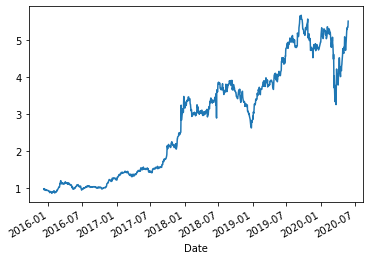

In [45]:
(returns.drop(index = returns.nsmallest(2, columns = ['daily_return']).index).groupby('Date')['daily_return'].mean() +1).cumprod().plot()

In [46]:
returns.drop(index = returns.nsmallest(2, columns = ['daily_return']).index).groupby('Date')['daily_return'].mean().describe()

count    1140.000000
mean        0.001791
std         0.024270
min        -0.176664
25%        -0.008277
50%         0.001175
75%         0.011576
max         0.264335
Name: daily_return, dtype: float64

In [47]:
print('\033[1m' + 'BACKTESTING RESULTS')
mean = returns.drop(index = returns.nsmallest(1, columns = ['daily_return']).index).groupby('Date')['daily_return'].mean().mean()*252*100
stdev = returns.drop(index = returns.nsmallest(1, columns = ['daily_return']).index).groupby('Date')['daily_return'].mean().std()*(252**0.5)*100
print('Average yearly returns: {}%'.format(round(mean,2)))
print('Average yearly standard deviation: {}%'.format(round(stdev,2)))
print('Sharpe Ratio: {}'.format((mean-0.005)/stdev)) #assuming rf is 0.005 (computed from FF website, average of the period)

BACKTESTING RESULTS
Average yearly returns: 44.01%
Average yearly standard deviation: 38.58%
Sharpe Ratio: 1.1405791585042762
